In [2]:
import keras.applications.vgg16
import keras.applications.resnet_v2
import keras.applications.mobilenet_v2
import keras.preprocessing.image
import keras.backend
import math

import matplotlib.pyplot
import numpy
import os
import pathlib

In [3]:
cfg={
    "list_of_labels": list(["manekia", "ottonia", "peperomia", "piper", "pothomorphe"]),
    "list_of_models": list(["mobilenetv2"]),
    "orientation": list(["vertical"]),
    "patches": list([3]),
    "height": 256,
    "width": 256,
}
list_imgs_sliced = list([])

In [4]:
def get_model(model, **kwargs):
    if model == "vgg16":
        return keras.applications.vgg16.VGG16(**kwargs), keras.applications.vgg16.preprocess_input
    if model == "resnet50v2":
        return keras.applications.resnet_v2.ResNet50V2(**kwargs), keras.applications.resnet_v2.preprocess_input
    if model == "mobilenetv2":
        return keras.applications.mobilenet_v2.MobileNetV2(**kwargs), keras.applications.mobilenet_v2.preprocess_input

    raise ValueError


def get_label(filename, labels):
    return next(labels.index(l) for l in labels if l in filename)


def save(features, labels, model_name, n_patches, orientation):
    path_out = os.path.join("out", model_name)
    pathlib.Path(path_out).mkdir(parents=True, exist_ok=True)
    output_filename = os.path.join(path_out, f"{orientation}+patch={n_patches}+{model_name}")
    numpy.savez_compressed(output_filename, features=features, labels=labels)
    print(output_filename, features.shape, labels.shape)


def get_input_shape(cfg, n_patches, orientation):
    if orientation == "vertical":
        return (cfg["height"], math.floor(cfg["width"] / n_patches), 3)
    if orientation == "horizontal":
        return (math.floor(cfg["height"] / n_patches), cfg["width"], 3)
    if orientation == "h+v":
        return (math.floor(cfg["height"] / n_patches), math.floor(cfg["width"] / n_patches), 3)
    return (cfg["height"], cfg["width"], 3)


def next_patch(orientation, spec, n):
    if orientation == "vertical":
        step = math.floor(spec.shape[1] / n)
        for i in range(n):
            yield spec[:, i * step:(i + 1) * step, :]
    elif orientation == "horizontal":
        step = math.floor(spec.shape[0] / n)
        for i in range(n):
            yield spec[i * step:(i + 1) * step, :, :]

In [15]:
for orientation in cfg["orientation"]:
    if not orientation in ("horizontal", "vertical", "h+v"):
        raise ValueError("orientation not found")
    for model_name in cfg["list_of_models"]:
        for n_patches in cfg["patches"]:
            if n_patches < 1:
                raise ValueError("n_patches should be greater than one")

            keras.backend.clear_session()

            input_shape = get_input_shape(cfg, n_patches, orientation)

            model, preprocess_input = get_model(model_name, weights="imagenet", include_top=False,
                                                input_shape=input_shape, pooling="avg")

            features = []
            labels = []
            for filename in sorted(pathlib.Path("dataset").rglob("*")):
                l = get_label(str(filename.stem), cfg["list_of_labels"])
                print(filename.resolve(), cfg["list_of_labels"][l], model_name, n_patches)
                img = keras.preprocessing.image.load_img(str(filename.resolve()))
                spec = keras.preprocessing.image.img_to_array(img)
                img_sliced = list([])
                if orientation == "h+v":
                    for p in next_patch("horizontal", spec, n_patches):
                        for q in next_patch("vertical", p, n_patches):
                            q = preprocess_input(q)
                            img_sliced.append(keras.preprocessing.image.array_to_img(q))
                            q = numpy.expand_dims(q, axis=0)
                            features.append(model.predict(q))
                            labels.append(l + 1)
                else:
                    for p in next_patch(orientation, spec, n_patches):
                        p = preprocess_input(p)
                        img_sliced.append(keras.preprocessing.image.array_to_img(p))
                        p = numpy.expand_dims(p, axis=0)
                        features.append(model.predict(p))
                        labels.append(l + 1)
                list_imgs_sliced.append({"img": img_sliced, "orientation": orientation, "patches": n_patches, "filename": str(filename.stem)})

            features = numpy.concatenate(features)
            labels = numpy.array(labels)
            save(features, labels, model_name, n_patches, orientation)

C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia01.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia02.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia03.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia04.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia05.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia06.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia07.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia08.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia09.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia10.png manekia mobilenetv2 3
C:\Users\xandao\Documents\GitKraken\deep_feature\dataset\manekia11.png

In [6]:
x = numpy.load("out/mobilenetv2/vertical+patch=3+mobilenetv2.npz")
numpy.unique(x["labels"])

array([1, 2, 3, 4, 5])

In [7]:
x["features"].shape

(1125, 1280)

In [8]:
len(list_imgs_sliced)

375

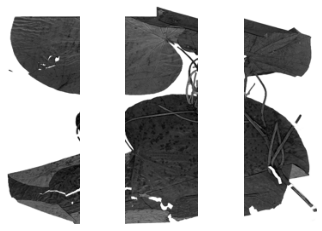

In [16]:
import matplotlib.pyplot

def get_fig(n_patches, orientation):
    if orientation == "horizontal":
        return matplotlib.pyplot.subplots(nrows=n_patches)
    if orientation == "vertical":
        return matplotlib.pyplot.subplots(ncols=n_patches)
    return matplotlib.pyplot.subplots(nrows=n_patches, ncols=n_patches)

pathlib.Path("imgs_sliced").mkdir(exist_ok=True, parents=True)
for img_sliced in list_imgs_sliced[len(list_imgs_sliced)-1:]:
    filename = f"{img_sliced['filename']}+{img_sliced['orientation']}+patch={img_sliced['patches']}.png"
    if not os.path.exists(os.path.join("imgs_sliced", filename)):
        figure, axis = get_fig(img_sliced["patches"], img_sliced["orientation"])
        if img_sliced["orientation"] == "h+v":
            for i in range(0, img_sliced["patches"]):
                for j, img in enumerate(img_sliced["img"]):
                    axis[i][j].imshow(img)
                    axis[i][j].axis("off")
        else:
            for i, img in enumerate(img_sliced["img"]):
                axis[i].imshow(img)
                axis[i].axis("off")
        # matplotlib.pyplot.show()
        figure.savefig(os.path.join("imgs_sliced", filename))